# Data Wrangling

This notebook documents the initial exploration steps for the project. In it, I examine how the data is oriented, and how the lines of dialogue are distributed among characters. I also do some basic prep work removing incorrect data and truncating the data set to focus on the primary characters.

In [1]:
# Load in the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

<b>Initial glance</b><br>
Checking the shape and structure of the data. The main data set is stored as `lines`.

In [2]:
lines = pd.read_csv('../data/All-seasons.csv')

In [3]:
lines.shape

(70896, 4)

In [4]:
lines.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [5]:
seasons = lines.loc[1:,'Season']
set(seasons)

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'Season'}

From the dataset, the only real features of concern are `Character` and `Line`. There are roughly 71,000 lines of dialogue across 18 seasons. One oddity is to see the word 'Season' mixed in with the season numbers.<br>
<br>
Taking a closer look, there looks to be a few superfluous lines, maybe extra headers for each season.

In [6]:
lines[lines.Season == 'Season']

,Season,Episode,Character,Line
3471,Season,Episode,Character,Line
6950,Season,Episode,Character,Line
10258,Season,Episode,Character,Line
13516,Season,Episode,Character,Line
16863,Season,Episode,Character,Line
19965,Season,Episode,Character,Line
23086,Season,Episode,Character,Line
25392,Season,Episode,Character,Line
27915,Season,Episode,Character,Line
32086,Season,Episode,Character,Line


These need to be dropped.

In [7]:
lines = lines[lines.Season != 'Season']
lines.shape

(70879, 4)

<b>Diving into the dialogue</b><br>
Are the lines of dialogue more or less evenly distributed across seasons?<br>
<br>
First, the entries for `Season` and `Episode` are converted from strings to integers. This allows for easier sorting and plotting.

In [8]:
lines[['Season', 'Episode']] = lines[['Season', 'Episode']].astype('int64')

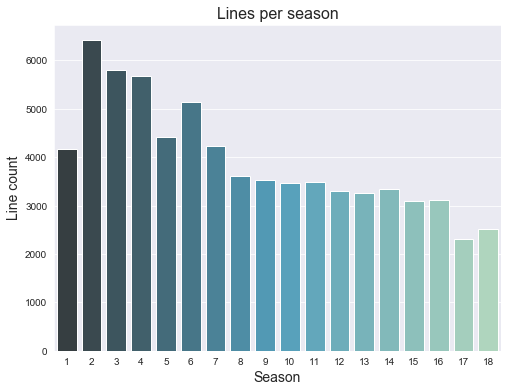

In [9]:
lines_per_season = lines.groupby('Season').count()[['Line']].sort_index()

fig = plt.subplots(figsize=(8,6))
_ = sns.barplot(lines_per_season.index, lines_per_season.Line, palette='GnBu_d')
_ = plt.xlabel('Season', fontsize=14)
_ = plt.ylabel('Line count', fontsize=14)
_ = plt.title('Lines per season', fontsize=16)

Seasons 2-4 are clearly the most dialogue heavy, but i don't think these differences are material to the problem at hand.

Let's see how many characters we're dealing with, and how the lines are broken down.

In [10]:
from collections import Counter

character_count = Counter(lines.Character)
len(character_count)

3949

There looks to be about 4,000 characters represented in the data which, for an eventual classification problem, means there are a lot of classes to deal with. Before dealing with that issue, let's see who has the bulk of the lines.

In [11]:
character_line_counts = character_count.most_common(15)
character_line_counts

[('Cartman', 9774),
 ('Stan', 7680),
 ('Kyle', 7099),
 ('Butters', 2602),
 ('Randy', 2467),
 ('Mr. Garrison', 1002),
 ('Chef', 917),
 ('Kenny', 881),
 ('Sharon', 862),
 ('Mr. Mackey', 633),
 ('Gerald', 626),
 ('Jimmy', 597),
 ('Wendy', 585),
 ('Liane', 582),
 ('Sheila', 566)]

Now to visualize it:

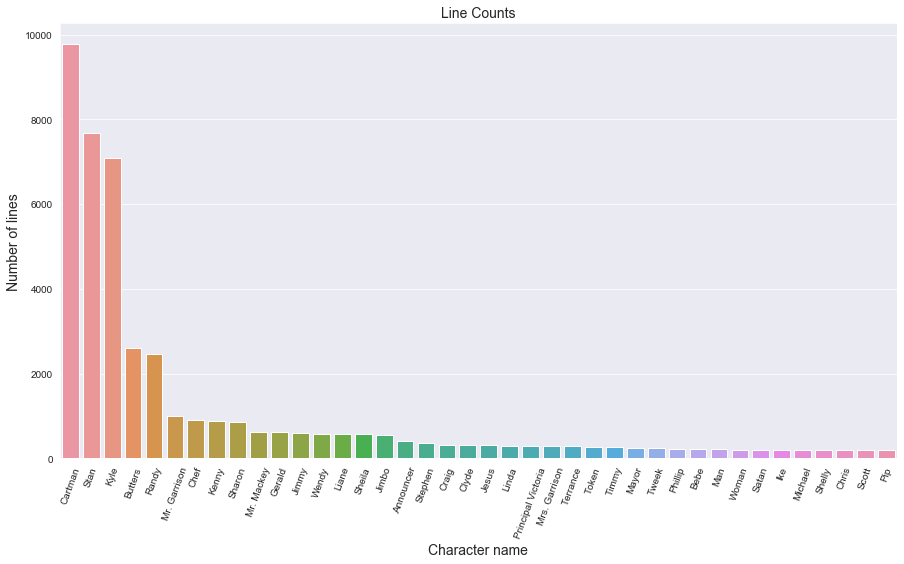

In [12]:
names = [tup[0] for tup in character_count.most_common(40)]
counts = [tup[1] for tup in character_count.most_common(40)]

fig = plt.subplots(figsize=(15,8))
_ = sns.barplot(names, counts)
_ = plt.xlabel('Character name', fontsize=14)
_ = plt.ylabel('Number of lines', fontsize=14)
_ = plt.title('Line Counts', fontsize=14)
_ = plt.xticks(rotation=70)

Unsurprisingly, even though there are a few thousand characters, only a few of them feature prominently. Most characters have minor supporting or guest roles.<br>
<br>
Because of this dynamic, for the scope of this project, it makes sense to cut out the insignificant classes and just focus on the main ones.<br>
<br>
Judging by the counts and the visualization, the first five characters clearly stand out and represent a sizeable chunk of dialogue. Additionally, I want to keep some of the supporting dialogue by lumping a few of the more important secondary characters into one group. This serves the dual purpose of minimizing data loss from dropping so many characters, and it creates a sort of control group for the classification later.

In [13]:
support_chars = ['Mr. Garrison', 'Chef', 'Sharon',\
                 'Mr. Mackey', 'Gerald', 'Liane', 'Sheila',\
                 'Stephen', 'Ms. Garrison', 'Mrs. Garrison']

With the characters chosen, they now need to be grouped together. Then any remaining support characters can be removed from the data. In the list above, I made sure to include all versions of Garrison as they are essentially all the same character.

In [14]:
lines.loc[lines.Character.isin(support_chars), 'Character'] = 'Support Character'

In [15]:
final_labels = ['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy', 'Support Character']

lines = lines[lines.Character.isin(final_labels)]
lines

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Support Character,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
5,10,1,Support Character,Wow!\n
6,10,1,Support Character,Chef?? What kind of questions do you think adv...
7,10,1,Support Character,What's the meaning of life? Why are we here?\n
8,10,1,Support Character,I hope you're making the right choice.\n
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...


There are roughly 35,500 lines of dialogue remaining for six class labels.<br>
<br>
Now that the data has been truncated, we can begin to examine the corpus of words in the next notebook, and study the differences between characters.